In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv("C:/Users/Smart/Desktop/Econ 213/train.csv")
test_df = pd.read_csv("C:/Users/Smart/Desktop/Econ 213/test.csv")

# Data Cleaning

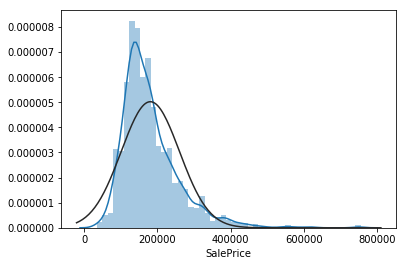

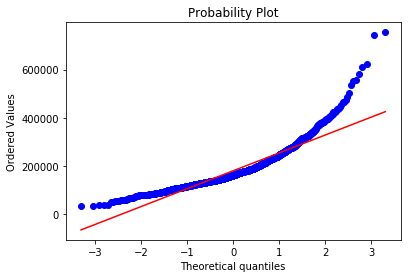

In [3]:
sns.distplot(train_df['SalePrice'], fit=norm)
fig = plt.figure()
prob_plt = stats.probplot(train_df['SalePrice'], plot=plt)
#SalePrice is skewed so let's normalize

In [4]:
#log transformation to normalize
train_df['SalePrice'] = np.log(train_df['SalePrice'])

Here I dropped these five variables as they were lacking large amounts of data.  

In [5]:
train_df = train_df.drop(['MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'Alley'], axis = 1)

Here I dropped these variables as they created problems with predicting after running my models.  We will see later on in my predictions that this is not that big of a problem in that many of these variables have othe variables that are very similiar in nature.

In [6]:
train_df = train_df.drop(['Condition2', 'Electrical', 'Exterior1st', 'Exterior2nd', 'GarageQual', 'Heating', 'HouseStyle',
                          'RoofMatl', 'Utilities'], axis = 1)

In [7]:
test_df = test_df.drop(['Condition2', 'Electrical', 'Exterior1st', 'Exterior2nd', 'GarageQual', 'Heating', 'HouseStyle',
                          'RoofMatl', 'Utilities'], axis = 1)

In [8]:
test_df = test_df.drop(['MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'Alley'], axis = 1)

In [9]:
#fill in missing data with mean and mode
for col in train_df:
    if train_df[col].dtype == 'O':
        train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

In [10]:
for col in train_df:
    if train_df[col].dtype == np.float64 or train_df[col].dtype == 'i':
        train_df[col] = train_df[col].fillna(train_df[col].mean())

In [11]:
#get dummies
train_df = pd.get_dummies(train_df)

# Linear Regression Model

In [12]:
target = train_df.SalePrice

In [13]:
train_df.drop(['SalePrice'], axis=1, inplace=True)

In [14]:
scaler = StandardScaler()
scaler.fit(train_df)
scaled_df = scaler.transform(train_df)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, target, test_size=0.2)

In [16]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 12.477779960143485
Test MSE: 0.7615102092992913


Here the mean squared errors indicate potential troubles.

Here I made all the changes to the test set that I previously made to the training set.

In [17]:
test_df = pd.get_dummies(test_df)

In [18]:
for col in test_df:
    if test_df[col].dtype == 'O':
        test_df[col] = test_df[col].fillna(train_df[col].mode()[0])

In [19]:
for col in test_df:
    if test_df[col].dtype == np.float64 or test_df[col].dtype == 'i':
        test_df[col] = test_df[col].fillna(train_df[col].mean())

In [20]:
scaler = StandardScaler()
scaler.fit(test_df)
scaled_df = scaler.transform(test_df)
test_predictions = linear_regression_model.predict(scaled_df)

Exponentiate SalePrice to get predictions in dollar values.

In [21]:
lin_preds = np.exp(test_predictions)

In [22]:
print(lin_preds)

[ 156941.99003259   29900.90241194   71923.66380332 ...,  215385.01880699
   79758.04267464  120503.08788156]


In [23]:
lin_preds.min()

8.7516632495678238e-34

As we can see he lowest prediction was 14$.  A little too good to be true of you ask me! I would obviously not be very confident presenting this to a company such as Zillow.  Let's see how the next few models fair.

In [24]:
test_ids = pd.DataFrame()
test_ids = test_df['Id']
test_df = test_df.drop(['Id'], axis=1, inplace=True)

In [25]:
my_submission = pd.DataFrame({'Id': test_ids, 'SalePrice': lin_preds})

my_submission.to_csv('submission1.csv', index=False)

# Elastic Net Model

In [26]:
from sklearn.linear_model import ElasticNetCV


reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10])
reg.fit(X_train, y_train)
train_predictions = reg.predict(X_train)
test_predictions = reg.predict(X_test)
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Train MSE: 0.017382994542808713
Test MSE: 0.016042352798100807


Look at those mean squared errors!  Looks like this model shows promise in better predicting SalePrice

In [27]:
ENCV_preds = reg.predict(scaled_df)

In [28]:
ENCV_preds = np.exp(reg.predict(scaled_df))

Checking the range of predicted SalePrice values.  Awesome this seems like a reasonable range of house values!

In [29]:
ENCV_preds.min()

53673.228196112672

In [30]:
ENCV_preds.max()

859690.34203134652

In [31]:
my_submission = pd.DataFrame({'Id': test_ids, 'SalePrice': ENCV_preds})

my_submission.to_csv('submission2.csv', index=False)

This model was the most interesting and did the best on kaggle. 

# K-Nearest Neighbors Model

In [32]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import NearestNeighbors

This model similar to the Elastic CV did rather well.  The mean squared errors seem to be reasonable and indicate a relatively low bias and normal fitting.

In [33]:
reg = KNeighborsRegressor()
gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11]})
gridsearch.fit(X_train, y_train)
gridsearch.predict(X_test)
train_predictions = gridsearch.predict(X_train)
test_predictions = gridsearch.predict(X_test)
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Train MSE: 0.0328000763333636
Test MSE: 0.03828370114461349


In [34]:
neigh_preds = gridsearch.predict(scaled_df)

In [35]:
neigh_preds = np.exp(neigh_preds)

Again I check the max and min SalePrice values and this range of values seems even more reasonable. 

In [36]:
neigh_preds.max()

418898.07591008628

In [37]:
neigh_preds.min()

67325.991620544708

In [38]:
my_submission = pd.DataFrame({'Id': test_ids, 'SalePrice': neigh_preds})

my_submission.to_csv('submission3.csv', index=False)

Between these last 2 models I would feel somewhat comfortable giving this data to a company like Zillow, albeit imperfect.
I really enjoyed this homework as difficult as it was, I do feel that I learned a lot and to be honest the fact that I got predictions on prices of houses within a reasonable range is something to get excited about.